In [2]:
# ignore warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
import eli5

In [6]:
data = pd.read_csv("data/ner_dataset.csv", encoding="utf-8")
data = data.fillna(method="ffill")
data.tail(10)

,Sentence #,Word,Tag
369382,Sentence: 16858,vùng,O
369383,Sentence: 16858,chôn_cất,O
369384,Sentence: 16858,người_thân,O
369385,Sentence: 16858,khi,O
369386,Sentence: 16858,qua_đời,O
369387,Sentence: 16858,",",O
369388,Sentence: 16858,gọi,O
369389,Sentence: 16858,là,O
369390,Sentence: 16858,nhị_tì,O
369391,Sentence: 16858,...,O


In [7]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [8]:
n_words = len(words); n_words

19152

In [9]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

5

In [10]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Đó', 'O'), ('là', 'O'), ('con', 'O'), ('đường', 'O'), ('biển', 'O'), ('ngắn', 'O'), ('nhất', 'O'), ('để', 'O'), ('đi', 'O'), ('từ', 'O'), ('Ấn_Độ_Dương', 'LOCATION'), ('sang', 'O'), ('Thái_Bình_Dương', 'LOCATION'), (',', 'O'), ('chiếm', 'O'), ('đến', 'O'), ('lượng', 'O'), ('hàng_hoá', 'O'), ('lưu_thông', 'O'), ('đường_biển', 'O'), ('của', 'O'), ('thế_giới', 'O'), (',', 'O'), ('đó', 'O'), ('là', 'O'), ('hải_trình', 'O'), ('lớn', 'O'), ('nhất', 'O'), ('từ', 'O'), ('tây', 'O'), ('sang', 'O'), ('đông', 'O'), ('với', 'O'), ('50.000', 'O'), ('lượt', 'O'), ('tàu_bè', 'O'), ('qua_lại', 'O'), ('mỗi', 'O'), ('năm', 'O'), ('...', 'O')]


In [12]:
sentences = getter.sentences

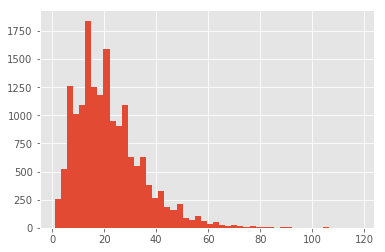

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [21]:
max_len = 120
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
word2idx["cửa_hàng"]

16546

In [23]:
tag2idx["PERSON"]

4

In [24]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [25]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [26]:
X[1]

array([14410, 16621,  2755,  6757,  9559,  5786, 18946, 18318,  3871,
        4675,  4001,  4511, 18640, 11481, 13119, 16284, 11518, 16689,
       11513,  9559, 13119,   897, 16320,  9722, 16123, 18846, 16547,
       16365, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151, 19151,
       19151, 19151, 19151])

In [28]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [29]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [30]:
y[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
from keras.utils import to_categorical

In [32]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [34]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [35]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [36]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 13654 samples, validate on 1518 samples
Epoch 1/5


 6496/13654 [=============>................] - ETA: 36:54 - loss: 1.6256 - acc: 0.01 - ETA: 19:37 - loss: 1.5562 - acc: 0.50 - ETA: 13:49 - loss: 1.4720 - acc: 0.66 - ETA: 10:57 - loss: 1.2928 - acc: 0.74 - ETA: 9:12 - loss: 1.0542 - acc: 0.7920 - ETA: 8:02 - loss: 0.8922 - acc: 0.824 - ETA: 7:12 - loss: 0.7767 - acc: 0.847 - ETA: 6:34 - loss: 0.6896 - acc: 0.864 - ETA: 6:04 - loss: 0.6215 - acc: 0.877 - ETA: 5:41 - loss: 0.5654 - acc: 0.888 - ETA: 5:22 - loss: 0.5208 - acc: 0.897 - ETA: 5:06 - loss: 0.4808 - acc: 0.905 - ETA: 4:52 - loss: 0.4488 - acc: 0.911 - ETA: 4:40 - loss: 0.4282 - acc: 0.916 - ETA: 4:30 - loss: 0.4048 - acc: 0.921 - ETA: 4:21 - loss: 0.3822 - acc: 0.925 - ETA: 4:13 - loss: 0.3639 - acc: 0.929 - ETA: 4:06 - loss: 0.3471 - acc: 0.932 - ETA: 3:59 - loss: 0.3338 - acc: 0.935 - ETA: 3:53 - loss: 0.3198 - acc: 0.937 - ETA: 3:47 - loss: 0.3088 - acc: 0.939 - ETA: 3:42 - loss: 0.2973 - acc: 0.942 - ETA: 3:38 - loss: 0.2866 - acc: 0.944 - ETA: 3:34 - loss: 0.2768 - acc: 

13312/13654 [============================>.] - ETA: 1:13 - loss: 0.0750 - acc: 0.983 - ETA: 1:12 - loss: 0.0749 - acc: 0.983 - ETA: 1:12 - loss: 0.0747 - acc: 0.983 - ETA: 1:11 - loss: 0.0745 - acc: 0.983 - ETA: 1:11 - loss: 0.0743 - acc: 0.983 - ETA: 1:11 - loss: 0.0741 - acc: 0.983 - ETA: 1:10 - loss: 0.0738 - acc: 0.983 - ETA: 1:10 - loss: 0.0737 - acc: 0.983 - ETA: 1:10 - loss: 0.0735 - acc: 0.983 - ETA: 1:09 - loss: 0.0733 - acc: 0.983 - ETA: 1:09 - loss: 0.0730 - acc: 0.983 - ETA: 1:09 - loss: 0.0728 - acc: 0.983 - ETA: 1:08 - loss: 0.0726 - acc: 0.984 - ETA: 1:08 - loss: 0.0724 - acc: 0.984 - ETA: 1:08 - loss: 0.0722 - acc: 0.984 - ETA: 1:07 - loss: 0.0720 - acc: 0.984 - ETA: 1:07 - loss: 0.0719 - acc: 0.984 - ETA: 1:07 - loss: 0.0717 - acc: 0.984 - ETA: 1:06 - loss: 0.0715 - acc: 0.984 - ETA: 1:06 - loss: 0.0713 - acc: 0.984 - ETA: 1:05 - loss: 0.0712 - acc: 0.984 - ETA: 1:05 - loss: 0.0710 - acc: 0.984 - ETA: 1:05 - loss: 0.0708 - acc: 0.984 - ETA: 1:04 - loss: 0.0706 - acc: 0

13654/13654 [==============================] - ETA: 3s - loss: 0.0487 - acc: 0.988 - ETA: 2s - loss: 0.0487 - acc: 0.988 - ETA: 2s - loss: 0.0486 - acc: 0.988 - ETA: 2s - loss: 0.0486 - acc: 0.988 - ETA: 1s - loss: 0.0485 - acc: 0.988 - ETA: 1s - loss: 0.0484 - acc: 0.988 - ETA: 1s - loss: 0.0484 - acc: 0.988 - ETA: 0s - loss: 0.0483 - acc: 0.988 - ETA: 0s - loss: 0.0482 - acc: 0.988 - ETA: 0s - loss: 0.0482 - acc: 0.988 - 138s 10ms/step - loss: 0.0481 - acc: 0.9883 - val_loss: 0.0195 - val_acc: 0.9936
Epoch 2/5


 6528/13654 [=============>................] - ETA: 2:19 - loss: 0.0191 - acc: 0.992 - ETA: 2:19 - loss: 0.0170 - acc: 0.993 - ETA: 2:19 - loss: 0.0193 - acc: 0.993 - ETA: 2:17 - loss: 0.0186 - acc: 0.994 - ETA: 2:15 - loss: 0.0187 - acc: 0.993 - ETA: 2:14 - loss: 0.0196 - acc: 0.993 - ETA: 2:14 - loss: 0.0189 - acc: 0.993 - ETA: 2:14 - loss: 0.0191 - acc: 0.993 - ETA: 2:13 - loss: 0.0182 - acc: 0.993 - ETA: 2:13 - loss: 0.0184 - acc: 0.993 - ETA: 2:13 - loss: 0.0184 - acc: 0.993 - ETA: 2:12 - loss: 0.0176 - acc: 0.994 - ETA: 2:12 - loss: 0.0170 - acc: 0.994 - ETA: 2:12 - loss: 0.0170 - acc: 0.994 - ETA: 2:11 - loss: 0.0169 - acc: 0.994 - ETA: 2:11 - loss: 0.0173 - acc: 0.994 - ETA: 2:11 - loss: 0.0171 - acc: 0.994 - ETA: 2:11 - loss: 0.0169 - acc: 0.994 - ETA: 2:11 - loss: 0.0169 - acc: 0.994 - ETA: 2:10 - loss: 0.0170 - acc: 0.994 - ETA: 2:10 - loss: 0.0171 - acc: 0.994 - ETA: 2:10 - loss: 0.0170 - acc: 0.994 - ETA: 2:10 - loss: 0.0170 - acc: 0.994 - ETA: 2:09 - loss: 0.0173 - acc: 0

13344/13654 [============================>.] - ETA: 1:12 - loss: 0.0154 - acc: 0.995 - ETA: 1:11 - loss: 0.0154 - acc: 0.995 - ETA: 1:11 - loss: 0.0154 - acc: 0.995 - ETA: 1:11 - loss: 0.0154 - acc: 0.995 - ETA: 1:10 - loss: 0.0154 - acc: 0.995 - ETA: 1:10 - loss: 0.0155 - acc: 0.995 - ETA: 1:10 - loss: 0.0155 - acc: 0.995 - ETA: 1:09 - loss: 0.0155 - acc: 0.995 - ETA: 1:09 - loss: 0.0155 - acc: 0.995 - ETA: 1:09 - loss: 0.0155 - acc: 0.995 - ETA: 1:08 - loss: 0.0155 - acc: 0.995 - ETA: 1:08 - loss: 0.0155 - acc: 0.995 - ETA: 1:08 - loss: 0.0155 - acc: 0.995 - ETA: 1:07 - loss: 0.0155 - acc: 0.995 - ETA: 1:07 - loss: 0.0154 - acc: 0.995 - ETA: 1:07 - loss: 0.0154 - acc: 0.995 - ETA: 1:06 - loss: 0.0154 - acc: 0.995 - ETA: 1:06 - loss: 0.0154 - acc: 0.995 - ETA: 1:06 - loss: 0.0154 - acc: 0.995 - ETA: 1:05 - loss: 0.0154 - acc: 0.995 - ETA: 1:05 - loss: 0.0154 - acc: 0.995 - ETA: 1:05 - loss: 0.0154 - acc: 0.995 - ETA: 1:05 - loss: 0.0153 - acc: 0.995 - ETA: 1:04 - loss: 0.0153 - acc: 0

13654/13654 [==============================] - ETA: 2s - loss: 0.0144 - acc: 0.995 - ETA: 2s - loss: 0.0144 - acc: 0.995 - ETA: 2s - loss: 0.0144 - acc: 0.995 - ETA: 1s - loss: 0.0144 - acc: 0.995 - ETA: 1s - loss: 0.0144 - acc: 0.995 - ETA: 1s - loss: 0.0144 - acc: 0.995 - ETA: 0s - loss: 0.0144 - acc: 0.995 - ETA: 0s - loss: 0.0144 - acc: 0.995 - ETA: 0s - loss: 0.0144 - acc: 0.995 - 141s 10ms/step - loss: 0.0144 - acc: 0.9956 - val_loss: 0.0123 - val_acc: 0.9963
Epoch 3/5


 6528/13654 [=============>................] - ETA: 2:13 - loss: 0.0153 - acc: 0.996 - ETA: 2:16 - loss: 0.0126 - acc: 0.996 - ETA: 2:16 - loss: 0.0104 - acc: 0.997 - ETA: 2:17 - loss: 0.0117 - acc: 0.996 - ETA: 2:15 - loss: 0.0114 - acc: 0.996 - ETA: 2:15 - loss: 0.0117 - acc: 0.996 - ETA: 2:14 - loss: 0.0114 - acc: 0.996 - ETA: 2:14 - loss: 0.0108 - acc: 0.996 - ETA: 2:13 - loss: 0.0100 - acc: 0.997 - ETA: 2:13 - loss: 0.0100 - acc: 0.997 - ETA: 2:12 - loss: 0.0101 - acc: 0.996 - ETA: 2:12 - loss: 0.0099 - acc: 0.996 - ETA: 2:11 - loss: 0.0096 - acc: 0.997 - ETA: 2:11 - loss: 0.0096 - acc: 0.997 - ETA: 2:11 - loss: 0.0097 - acc: 0.996 - ETA: 2:10 - loss: 0.0096 - acc: 0.997 - ETA: 2:10 - loss: 0.0097 - acc: 0.996 - ETA: 2:10 - loss: 0.0101 - acc: 0.996 - ETA: 2:10 - loss: 0.0098 - acc: 0.996 - ETA: 2:09 - loss: 0.0102 - acc: 0.996 - ETA: 2:09 - loss: 0.0104 - acc: 0.996 - ETA: 2:09 - loss: 0.0104 - acc: 0.996 - ETA: 2:08 - loss: 0.0108 - acc: 0.996 - ETA: 2:08 - loss: 0.0108 - acc: 0

13344/13654 [============================>.] - ETA: 1:11 - loss: 0.0100 - acc: 0.996 - ETA: 1:11 - loss: 0.0100 - acc: 0.997 - ETA: 1:10 - loss: 0.0100 - acc: 0.996 - ETA: 1:10 - loss: 0.0100 - acc: 0.997 - ETA: 1:10 - loss: 0.0100 - acc: 0.997 - ETA: 1:09 - loss: 0.0100 - acc: 0.997 - ETA: 1:09 - loss: 0.0100 - acc: 0.997 - ETA: 1:09 - loss: 0.0099 - acc: 0.997 - ETA: 1:08 - loss: 0.0100 - acc: 0.997 - ETA: 1:08 - loss: 0.0099 - acc: 0.997 - ETA: 1:08 - loss: 0.0099 - acc: 0.997 - ETA: 1:07 - loss: 0.0099 - acc: 0.997 - ETA: 1:07 - loss: 0.0100 - acc: 0.997 - ETA: 1:07 - loss: 0.0099 - acc: 0.997 - ETA: 1:06 - loss: 0.0100 - acc: 0.996 - ETA: 1:06 - loss: 0.0099 - acc: 0.997 - ETA: 1:06 - loss: 0.0099 - acc: 0.997 - ETA: 1:05 - loss: 0.0099 - acc: 0.997 - ETA: 1:05 - loss: 0.0099 - acc: 0.997 - ETA: 1:05 - loss: 0.0099 - acc: 0.997 - ETA: 1:04 - loss: 0.0099 - acc: 0.997 - ETA: 1:04 - loss: 0.0099 - acc: 0.997 - ETA: 1:04 - loss: 0.0100 - acc: 0.996 - ETA: 1:03 - loss: 0.0100 - acc: 0

13654/13654 [==============================] - ETA: 2s - loss: 0.0094 - acc: 0.997 - ETA: 2s - loss: 0.0094 - acc: 0.997 - ETA: 2s - loss: 0.0094 - acc: 0.997 - ETA: 1s - loss: 0.0093 - acc: 0.997 - ETA: 1s - loss: 0.0093 - acc: 0.997 - ETA: 1s - loss: 0.0093 - acc: 0.997 - ETA: 0s - loss: 0.0093 - acc: 0.997 - ETA: 0s - loss: 0.0093 - acc: 0.997 - ETA: 0s - loss: 0.0093 - acc: 0.997 - 141s 10ms/step - loss: 0.0093 - acc: 0.9971 - val_loss: 0.0095 - val_acc: 0.9971
Epoch 4/5


 6528/13654 [=============>................] - ETA: 2:13 - loss: 0.0059 - acc: 0.998 - ETA: 2:12 - loss: 0.0066 - acc: 0.997 - ETA: 2:12 - loss: 0.0060 - acc: 0.998 - ETA: 2:12 - loss: 0.0059 - acc: 0.998 - ETA: 2:13 - loss: 0.0057 - acc: 0.998 - ETA: 2:12 - loss: 0.0058 - acc: 0.998 - ETA: 2:13 - loss: 0.0060 - acc: 0.997 - ETA: 2:12 - loss: 0.0056 - acc: 0.998 - ETA: 2:12 - loss: 0.0058 - acc: 0.998 - ETA: 2:12 - loss: 0.0064 - acc: 0.997 - ETA: 2:12 - loss: 0.0065 - acc: 0.997 - ETA: 2:11 - loss: 0.0063 - acc: 0.998 - ETA: 2:11 - loss: 0.0059 - acc: 0.998 - ETA: 2:11 - loss: 0.0059 - acc: 0.998 - ETA: 2:11 - loss: 0.0064 - acc: 0.998 - ETA: 2:11 - loss: 0.0065 - acc: 0.997 - ETA: 2:11 - loss: 0.0063 - acc: 0.998 - ETA: 2:10 - loss: 0.0064 - acc: 0.998 - ETA: 2:10 - loss: 0.0065 - acc: 0.998 - ETA: 2:09 - loss: 0.0067 - acc: 0.998 - ETA: 2:09 - loss: 0.0066 - acc: 0.998 - ETA: 2:09 - loss: 0.0064 - acc: 0.998 - ETA: 2:08 - loss: 0.0064 - acc: 0.998 - ETA: 2:08 - loss: 0.0065 - acc: 0

13344/13654 [============================>.] - ETA: 1:11 - loss: 0.0072 - acc: 0.997 - ETA: 1:11 - loss: 0.0072 - acc: 0.997 - ETA: 1:10 - loss: 0.0072 - acc: 0.997 - ETA: 1:10 - loss: 0.0072 - acc: 0.997 - ETA: 1:10 - loss: 0.0071 - acc: 0.997 - ETA: 1:09 - loss: 0.0071 - acc: 0.997 - ETA: 1:09 - loss: 0.0071 - acc: 0.997 - ETA: 1:09 - loss: 0.0071 - acc: 0.997 - ETA: 1:08 - loss: 0.0071 - acc: 0.997 - ETA: 1:08 - loss: 0.0071 - acc: 0.997 - ETA: 1:08 - loss: 0.0071 - acc: 0.998 - ETA: 1:07 - loss: 0.0071 - acc: 0.998 - ETA: 1:07 - loss: 0.0071 - acc: 0.998 - ETA: 1:07 - loss: 0.0071 - acc: 0.998 - ETA: 1:06 - loss: 0.0071 - acc: 0.997 - ETA: 1:06 - loss: 0.0071 - acc: 0.998 - ETA: 1:06 - loss: 0.0071 - acc: 0.998 - ETA: 1:05 - loss: 0.0070 - acc: 0.998 - ETA: 1:05 - loss: 0.0071 - acc: 0.998 - ETA: 1:05 - loss: 0.0071 - acc: 0.998 - ETA: 1:04 - loss: 0.0071 - acc: 0.998 - ETA: 1:04 - loss: 0.0071 - acc: 0.998 - ETA: 1:04 - loss: 0.0071 - acc: 0.997 - ETA: 1:03 - loss: 0.0071 - acc: 0

13654/13654 [==============================] - ETA: 2s - loss: 0.0066 - acc: 0.998 - ETA: 2s - loss: 0.0067 - acc: 0.998 - ETA: 2s - loss: 0.0067 - acc: 0.998 - ETA: 1s - loss: 0.0067 - acc: 0.998 - ETA: 1s - loss: 0.0066 - acc: 0.998 - ETA: 1s - loss: 0.0066 - acc: 0.998 - ETA: 0s - loss: 0.0066 - acc: 0.998 - ETA: 0s - loss: 0.0066 - acc: 0.998 - ETA: 0s - loss: 0.0066 - acc: 0.998 - 141s 10ms/step - loss: 0.0066 - acc: 0.9980 - val_loss: 0.0093 - val_acc: 0.9972
Epoch 5/5


 6528/13654 [=============>................] - ETA: 2:19 - loss: 0.0059 - acc: 0.998 - ETA: 2:16 - loss: 0.0066 - acc: 0.998 - ETA: 2:16 - loss: 0.0049 - acc: 0.998 - ETA: 2:15 - loss: 0.0056 - acc: 0.998 - ETA: 2:14 - loss: 0.0051 - acc: 0.998 - ETA: 2:13 - loss: 0.0056 - acc: 0.998 - ETA: 2:13 - loss: 0.0051 - acc: 0.998 - ETA: 2:13 - loss: 0.0051 - acc: 0.998 - ETA: 2:12 - loss: 0.0052 - acc: 0.998 - ETA: 2:12 - loss: 0.0053 - acc: 0.998 - ETA: 2:12 - loss: 0.0050 - acc: 0.998 - ETA: 2:12 - loss: 0.0051 - acc: 0.998 - ETA: 2:11 - loss: 0.0050 - acc: 0.998 - ETA: 2:11 - loss: 0.0047 - acc: 0.998 - ETA: 2:11 - loss: 0.0046 - acc: 0.998 - ETA: 2:10 - loss: 0.0045 - acc: 0.998 - ETA: 2:10 - loss: 0.0047 - acc: 0.998 - ETA: 2:10 - loss: 0.0047 - acc: 0.998 - ETA: 2:09 - loss: 0.0051 - acc: 0.998 - ETA: 2:09 - loss: 0.0052 - acc: 0.998 - ETA: 2:09 - loss: 0.0050 - acc: 0.998 - ETA: 2:09 - loss: 0.0052 - acc: 0.998 - ETA: 2:08 - loss: 0.0053 - acc: 0.998 - ETA: 2:08 - loss: 0.0052 - acc: 0

13344/13654 [============================>.] - ETA: 1:11 - loss: 0.0053 - acc: 0.998 - ETA: 1:11 - loss: 0.0053 - acc: 0.998 - ETA: 1:10 - loss: 0.0053 - acc: 0.998 - ETA: 1:10 - loss: 0.0052 - acc: 0.998 - ETA: 1:10 - loss: 0.0052 - acc: 0.998 - ETA: 1:09 - loss: 0.0052 - acc: 0.998 - ETA: 1:09 - loss: 0.0052 - acc: 0.998 - ETA: 1:09 - loss: 0.0052 - acc: 0.998 - ETA: 1:08 - loss: 0.0052 - acc: 0.998 - ETA: 1:08 - loss: 0.0052 - acc: 0.998 - ETA: 1:08 - loss: 0.0052 - acc: 0.998 - ETA: 1:07 - loss: 0.0052 - acc: 0.998 - ETA: 1:07 - loss: 0.0052 - acc: 0.998 - ETA: 1:07 - loss: 0.0053 - acc: 0.998 - ETA: 1:06 - loss: 0.0053 - acc: 0.998 - ETA: 1:06 - loss: 0.0053 - acc: 0.998 - ETA: 1:06 - loss: 0.0053 - acc: 0.998 - ETA: 1:06 - loss: 0.0053 - acc: 0.998 - ETA: 1:05 - loss: 0.0053 - acc: 0.998 - ETA: 1:05 - loss: 0.0053 - acc: 0.998 - ETA: 1:05 - loss: 0.0053 - acc: 0.998 - ETA: 1:04 - loss: 0.0053 - acc: 0.998 - ETA: 1:04 - loss: 0.0053 - acc: 0.998 - ETA: 1:04 - loss: 0.0053 - acc: 0

13654/13654 [==============================] - ETA: 2s - loss: 0.0052 - acc: 0.998 - ETA: 2s - loss: 0.0052 - acc: 0.998 - ETA: 2s - loss: 0.0052 - acc: 0.998 - ETA: 1s - loss: 0.0052 - acc: 0.998 - ETA: 1s - loss: 0.0052 - acc: 0.998 - ETA: 1s - loss: 0.0052 - acc: 0.998 - ETA: 0s - loss: 0.0052 - acc: 0.998 - ETA: 0s - loss: 0.0052 - acc: 0.998 - ETA: 0s - loss: 0.0052 - acc: 0.998 - 141s 10ms/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0077 - val_acc: 0.9978


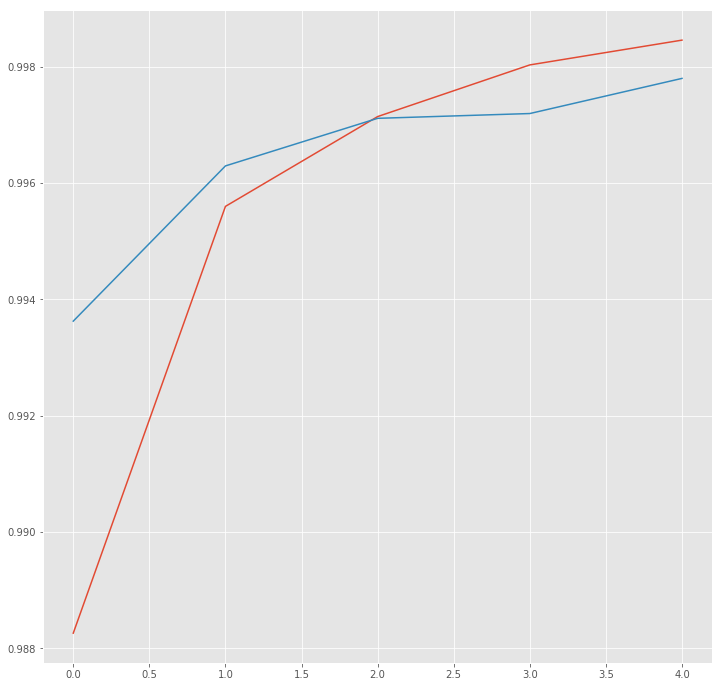

In [37]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [43]:
i = 169
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
Ở              : O
cửa_biển       : O
sông           : LOCATION
Ông_Đốc        : LOCATION
,              : O
huyện          : LOCATION
Trần           : LOCATION
Văn            : LOCATION
Thời           : LOCATION
,              : O
số             : O
trẻ            : O
thất_học       : O
vẫn            : O
không          : O
được           : O
thống_kê       : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         :